In [1]:
## Imports
import sys
import os
import time
import math
import random
import pdb
import h5py
import glob

# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import ImageGrid

import torchvision.utils as vutils    
from torch import from_numpy

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
from io_utils.data_handling_hitarray_train import WCH5DatasetT

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2
from utils.plot_utils import get_plot_array
from sklearn.metrics import roc_curve, auc

In [2]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def disp_learn_hist_smoothed(location, losslim=None, window_train=400,window_val=40,show=True):
    train_log=location+'/log_train.csv'
    
    train_log_csv = pd.read_csv(train_log)

    epoch_train    = moving_average(np.array(train_log_csv.epoch),window_train)
    gloss_train = moving_average(np.array(train_log_csv.g_loss),window_train)
    dloss_train     = moving_average(np.array(train_log_csv.d_loss),window_train)

    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    line11 = ax1.plot(epoch_train, dloss_train, linewidth=2, label='Average training D loss', color='b', alpha=0.3)
    
    ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('D Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)
   
    '''
    if losslim is not None:
        ax1.set_ylim(0.,losslim)
    else:
        ax1.set_ylim(0.,1.5)
    '''
    
    ax2 = ax1.twinx()
    line21 = ax2.plot(epoch_train, gloss_train, linewidth=2, label='Average training G loss', color='r', alpha=0.3)

    
    ax2.set_ylabel('G Loss', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    
    # added these four lines
    #lines  = line11+ line12+ [line13]+ line21+ line22+ [line23]
    lines  = line11+  line21
    #lines_sctr=[line13,line23]
    #lines=lines_plt+lines_sctr

    labels = [l.get_label() for l in lines]
    
    leg    = ax2.legend(lines, labels, fontsize=16, loc=5, numpoints=1)
    leg_frame = leg.get_frame()
    leg_frame.set_facecolor('white')

    if show:
        plt.grid()
        plt.show()
        return

    return fig

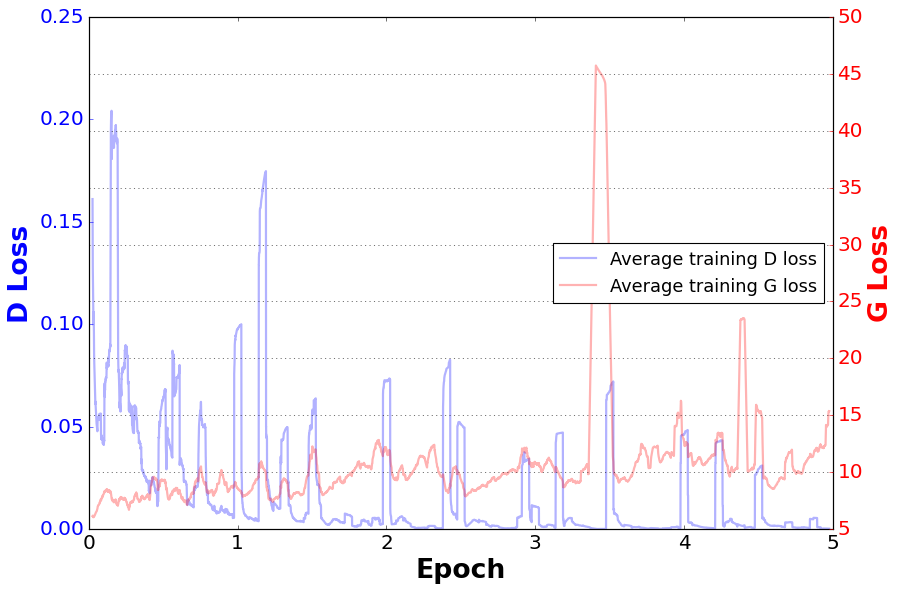

In [4]:
disp_learn_hist_smoothed('/home/cmacdonald/CNN/dumps/20200814_170837_gan_19channels_randominit')

In [5]:
image_batches = [np.load(fname,allow_pickle=True)['gen_imgs'] for fname in glob.glob(os.path.join('/home/cmacdonald/CNN/dumps/20200814_170837_gan_19channels_randominit','imgs/*'))]

In [6]:
len(image_batches)

10

In [7]:
batch_grids=[]
for image_batch in image_batches:
    batch_grid = np.concatenate([np.pad(np.squeeze(img),2,mode='constant',constant_values=(np.nan,)) for img in image_batch[0:8]],axis=1)
    for row_index in range(1,8,1):
        image_row = np.concatenate([np.pad(np.squeeze(img),2,mode='constant',constant_values=(np.nan,)) for img in image_batch[row_index*8:(row_index+1)*8]],axis=1)
        batch_grid = np.concatenate((batch_grid,image_row),axis=0)
    batch_grids.append(batch_grid)

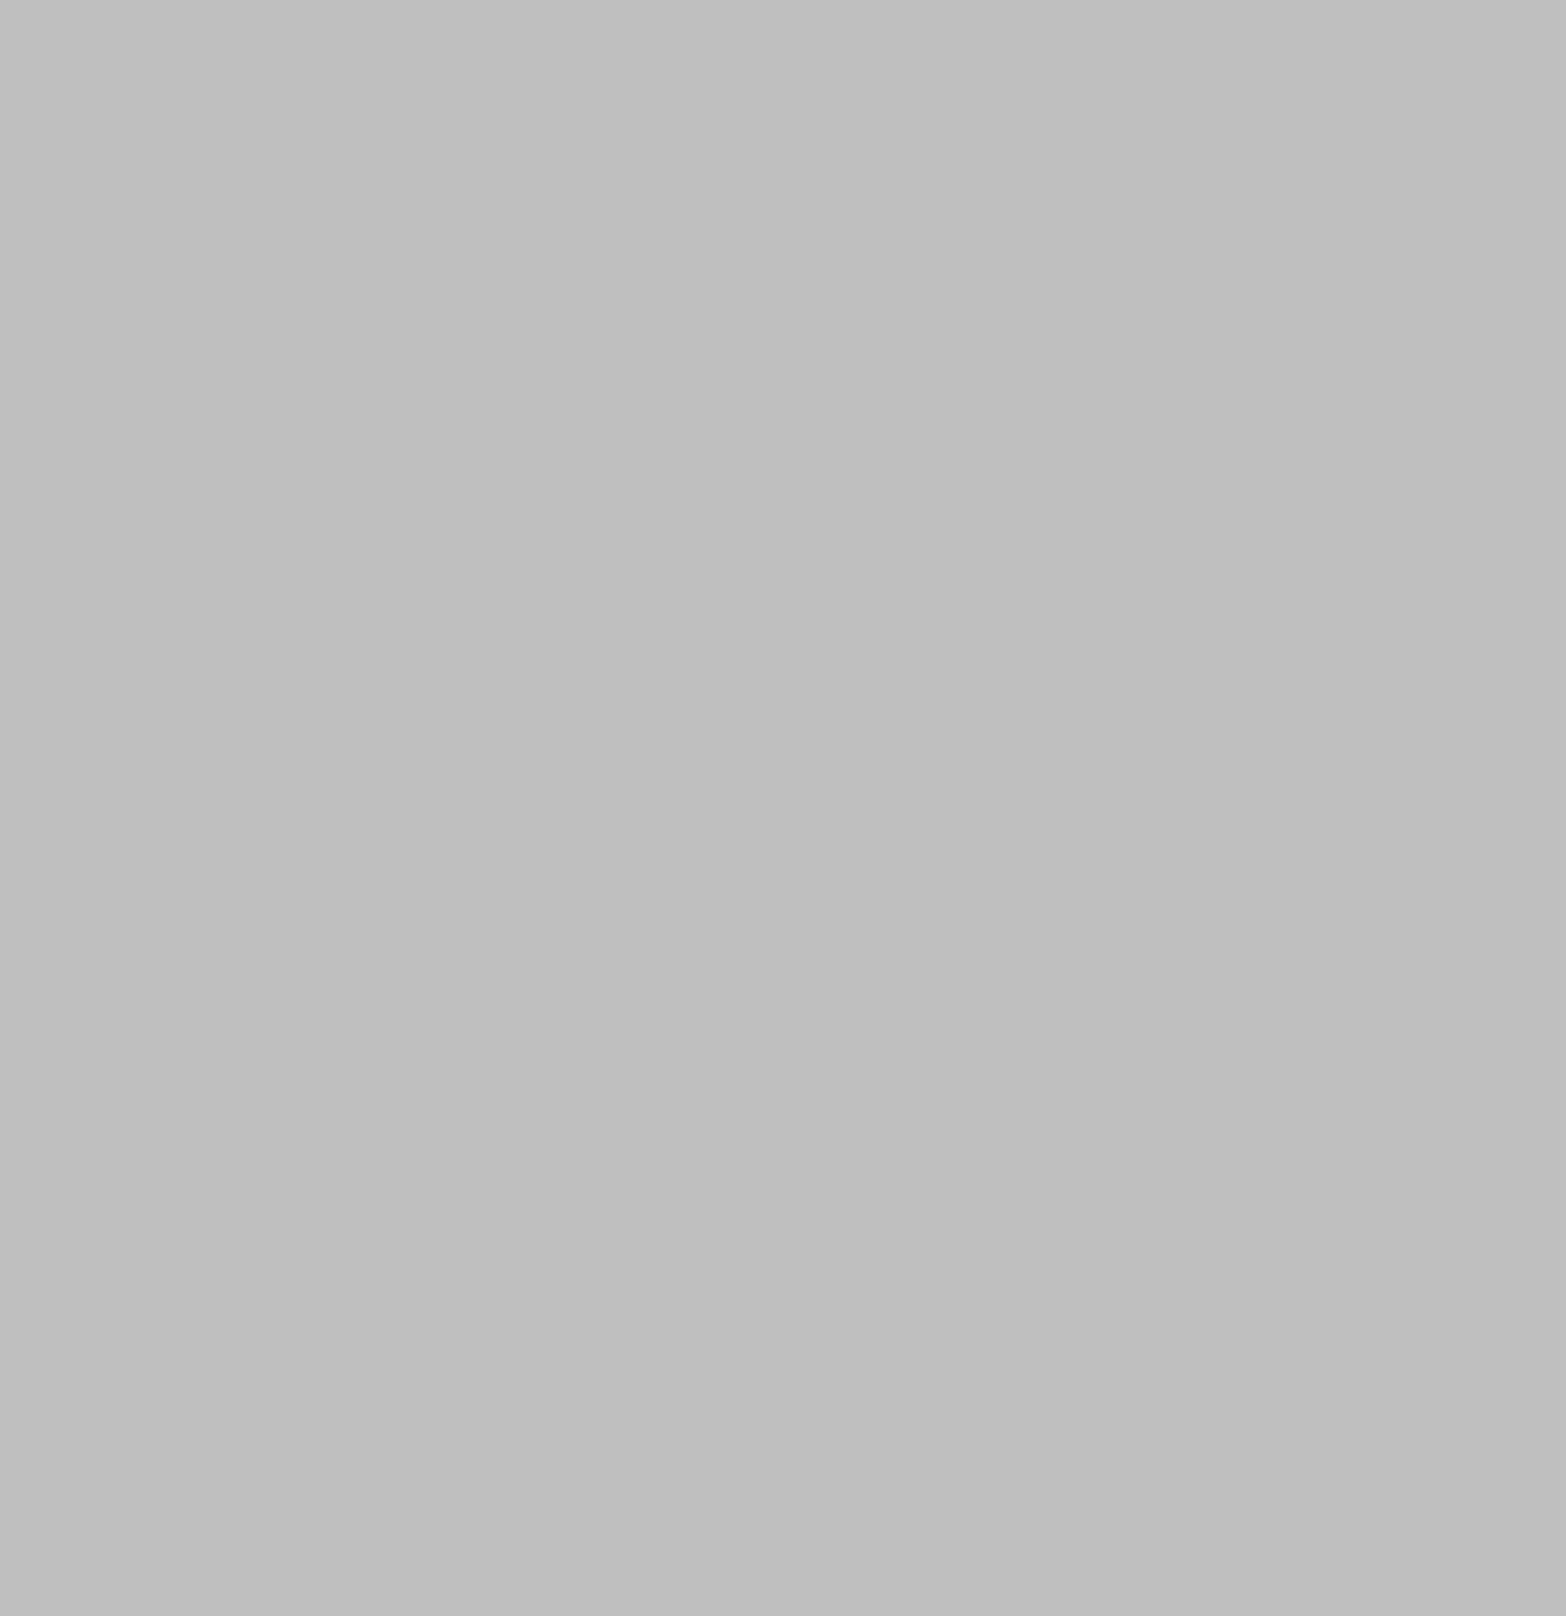

In [8]:
fig = plt.figure(figsize=(25,25))
display_imgs=[batch_grids[5 * i] for i in range(int(len(batch_grids)/15))]
plt.axis("off")
ims = [[plt.imshow(img[:,:], animated=True,cmap=plt.cm.viridis)] for img in display_imgs]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

TypeError: Invalid shape (184, 352, 44) for image data

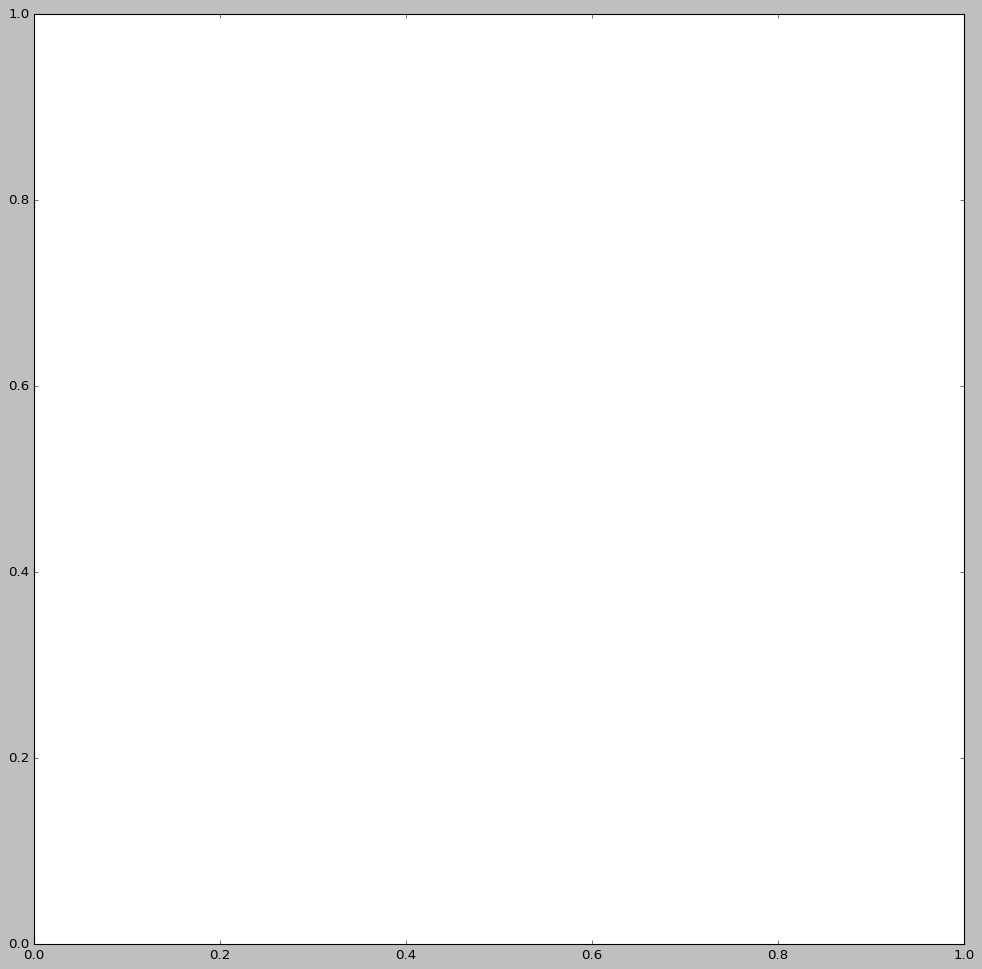

In [9]:
fig=plt.figure(figsize=(15,15))
plt.imshow(batch_grids[-1],cmap=plt.cm.viridis)

## Note: the model above was trained on a dataset which had massively scaled charge values, some of which were negative

In [ ]:
from io_utils.data_handling_hitarray_train import WCH5DatasetT
dset = WCH5DatasetT( ['/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_full_tank_pointnet.h5'], ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz'], '/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_norm_params/IWCDmPMT_4pi_fulltank_9M_trainval_norm_params.npz', chrg_norm="identity", time_norm="identity", shuffle=1, collapse_arrays=True,trainval_subset=None, num_datasets = 1, seed=42)

In [ ]:
image_batch_dset = [dset[idx][0]/np.max(dset[idx][0]) for idx in np.random.randint(0,high=len(dset),size=64)]

In [ ]:
batch_grid_dset = np.concatenate([np.pad(np.squeeze(img),2,mode='constant',constant_values=(np.nan,)) for img in image_batch_dset[0:8]],axis=1)
for row_index in range(1,8,1):
    image_row = np.concatenate([np.pad(np.squeeze(img),2,mode='constant',constant_values=(np.nan,)) for img in image_batch_dset[row_index*8:(row_index+1)*8]],axis=1)
    batch_grid_dset = np.concatenate((batch_grid_dset,image_row),axis=0)

In [ ]:
fig = plt.figure(figsize=(25,25))
plt.imshow(batch_grid_dset, animated=False,cmap=plt.cm.viridis)

In [ ]:
count=0
for i in np.random.choice(len(dset),size=100000,replace=False):
    if np.min(dset[i][0]) < 0: count +=1
print(count/100000)

In [ ]:
import os

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
from io_utils.data_handling_hitarray_train import WCH5DatasetT
dset = WCH5DatasetT( ['/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_full_tank_pointnet.h5'], ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz'], '/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_norm_params/IWCDmPMT_4pi_fulltank_9M_trainval_norm_params.npz', chrg_norm="identity", time_norm="identity", shuffle=1, collapse_arrays=False,trainval_subset=None, num_datasets = 1, seed=42)
example_event=np.squeeze(dset[0][0])
print(f'Max: {np.max(example_event)} Min: {np.min(example_event)}')

In [ ]:
example_event.dtype

In [ ]:
hit_charges=np.random.randint(0,high=1000, dtype = np.int16, size=500)
hit_cols=np.random.randint(0,high=40, dtype = np.int16, size=500)
hit_rows=np.random.randint(0,high=40, dtype = np.int16, size=500)
hit_pmt_in_modules = np.random.randint(0,high=19, dtype = np.int16, size=500)
data = np.zeros((19,40,40))
data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

In [ ]:
data=bogus_data

In [ ]:
np.min(data)

In [ ]:
from io_utils.data_handling_train import WCH5DatasetT
old_dset = WCH5DatasetT( ['/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5'], ['/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz'], '/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_norm_params/IWCDmPMT_4pi_fulltank_9M_trainval_norm_params.npz', chrg_norm="identity", time_norm="identity", shuffle=1,trainval_subset=None, num_datasets = 1, seed=42)

In [ ]:
old_example_event=old_dset[444][0]

In [ ]:
plt.imshow(np.squeeze(np.sum(old_example_event,axis=0)),cmap=plt.cm.viridis)

In [ ]:
np.min(old_example_event)

In [ ]:
np.max(old_example_event)

In [ ]:
for i in np.random.randint(0,high=len(old_dset),size=10000):
    assert np.min(old_dset[i][0])>=0